<a href="https://colab.research.google.com/github/tfreyd/TensorflowCoursera/blob/main/C4/W4/ungraded_labs/C4_W4_Lab_1_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.6.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [4]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.falt_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [5]:
tf.keras.backend.clear_session() 
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30 
train_set = windowed_dataset ( x_train, window_size, batch_size=128, shuffle_buffer = shuffle_buffer_size)

model = tf.keras.models.Sequential ([
  tf.keras.layers.Conv1D(32, kernel_size=5,strides=1, padding = 'causal',activation='relu',input_shape=[None,1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x : x * 200)                     
])


#setting up the callback to find the best learning rate 
lr_schedule = tf.keras.callbacks.LearningRateScheduler( lambda epoch: 1e-8 * 10**(epoch/20))

optimizer  = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum= 0.9)

model.compile(loss=tf.keras.losses.Huber(),
optimizer = optimizer, metrics=['mae'])

history= model.fit(train_set, epochs = 100, callbacks = [lr_schedule])

Epoch 1/100
8/8 [==============================] - 22s 24ms/step - loss: 34.0438 - mae: 34.5416
Epoch 2/100
8/8 [==============================] - 0s 16ms/step - loss: 33.0697 - mae: 33.5672
Epoch 3/100
8/8 [==============================] - 0s 16ms/step - loss: 31.4026 - mae: 31.8998
Epoch 4/100
8/8 [==============================] - 0s 18ms/step - loss: 29.2024 - mae: 29.6995
Epoch 5/100
8/8 [==============================] - 0s 16ms/step - loss: 26.4395 - mae: 26.9352
Epoch 6/100
8/8 [==============================] - 0s 14ms/step - loss: 23.2858 - mae: 23.7805
Epoch 7/100
8/8 [==============================] - 0s 14ms/step - loss: 20.0954 - mae: 20.5887
Epoch 8/100
8/8 [==============================] - 0s 14ms/step - loss: 17.4126 - mae: 17.9056
Epoch 9/100
8/8 [==============================] - 0s 15ms/step - loss: 15.5792 - mae: 16.0712
Epoch 10/100
8/8 [==============================] - 0s 17ms/step - loss: 14.5424 - mae: 15.0343
Epoch 11/100
8/8 [==============================

In [12]:
type(history)

keras.callbacks.History

In [15]:
history.history.items()

dict_items([('loss', [34.043758392333984, 33.06971740722656, 31.402559280395508, 29.202438354492188, 26.43948745727539, 23.28584861755371, 20.095441818237305, 17.4125919342041, 15.57919692993164, 14.542366027832031, 14.071036338806152, 13.842235565185547, 13.677248001098633, 13.530871391296387, 13.382609367370605, 13.226524353027344, 13.053573608398438, 12.86333179473877, 12.652050971984863, 12.40989875793457, 12.136545181274414, 11.832663536071777, 11.497617721557617, 11.152894020080566, 10.803010940551758, 10.46452522277832, 10.13122844696045, 9.825438499450684, 9.536155700683594, 9.28492259979248, 9.07387638092041, 8.897534370422363, 8.742653846740723, 8.59851360321045, 8.452001571655273, 8.30491828918457, 8.1552095413208, 7.999436378479004, 7.840369701385498, 7.68049430847168, 7.5224714279174805, 7.367245674133301, 7.225010395050049, 7.092428684234619, 6.953490734100342, 6.8249993324279785, 6.7005534172058105, 6.564026355743408, 6.441644191741943, 6.283385276794434, 6.1271352767944

In [19]:
learnig_rate=history.history['lr']
loss_values=history.history['loss']

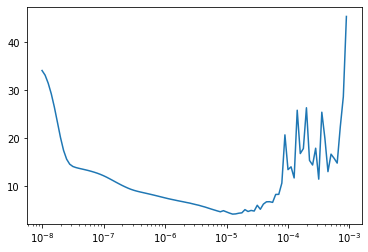

In [24]:
plt.semilogx(learnig_rate,loss_values)

The best learning rate is 10e-5.